In [2]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from metpy.plots import USCOUNTIES
import metpy
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import numpy as np
from pathlib import Path
from typing import Union
import os

C:\Users\Tony\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [40]:
## A couple functions are from Tim Supinie's gridradpy repository on GitHub (https://github.com/tsupinie/gridradpy/tree/main) with some modifications ##

_index_variables = ['Reflectivity', 'wReflectivity', 'SpectrumWidth', 'wSpectrumWidth', 'AzShear', 'wAzShear', 
                    'Divergence', 'wDivergence', 'DifferentialReflectivity', 'wDifferentialReflectivity',
                    'DifferentialPhase', 'wDifferentialPhase', 'CorrelationCoefficient', 'wCorrelationCoefficient']

def read_file(infile: Union[str, Path]) -> xr.Dataset:
    ds = xr.open_dataset(infile)

    nlon = ds.dims['Longitude']
    nlat = ds.dims['Latitude']
    nalt = ds.dims['Altitude']

    index = ds['index'].values

    da_dict = {}
    for var in _index_variables:
        if var not in ds.variables:
            continue

        # Create arrays to store binned values for reflectivity at horizontal polarization
        values    = np.zeros(nlon * nlat * nalt, dtype=np.float32)
        values[:] = np.nan

        # Add values to arrays
        values[index[:]]  =  ds[var].values[:]
        da = xr.DataArray(data=values.reshape((nalt, nlat, nlon)), coords=ds['Nradobs'].coords, 
                          dims=ds['Nradobs'].dims, name=ds[var].name, attrs=ds[var].attrs)

        da_dict[var] = da

    ds = ds.assign(**da_dict)

    return ds.drop_vars('index')

# GridRad filter routine
def filter(ds: xr.Dataset, wthresh=1.5, freq_thresh=0.6, Z_H_thresh=15.0, nobs_thresh=2):
    """
    wthresh:        Bin weight threshold for filtering by year (dimensionless)
    freq_thresh:    Echo frequency threshold (dimensionless)
    Z_H_thresh:     Reflectivity threshold (dBZ)
    nobs_thresh:    Number of observations threshold
    """

    has_data = ds['Nradobs'] > 0
    echo_frequency = (ds['Nradecho'] / ds['Nradobs']).where(has_data, 0.)

    # Find observations with low weight
    mask = ~(((ds['wReflectivity'] < wthresh) & (ds['Reflectivity'] < Z_H_thresh)) |
             ((echo_frequency < freq_thresh) & (ds['Nradobs'] > nobs_thresh)))
    
    # Remove low confidence observations
    if has_data.any():
        da_dict = {}
        for var in _index_variables:
            if var.startswith('w') or var not in ds.variables:
                continue
            
            da_dict[var] = ds[var].where(mask)

        ds = ds.assign(**da_dict)
    
    # Return filtered data0
    return ds

# Gridrad clutter filter routine
def remove_clutter(ds: xr.Dataset, skip_weak_ll_echo=False, areal_coverage_thresh=0.32) -> xr.Dataset:
    """
    areal_coverage_thresh:  Fractional areal coverage threshold for speckle identification
    """
    
    da = ds['Reflectivity']
    clutter = xr.DataArray(data=np.zeros_like(da.values, dtype=bool), coords=da.coords, dims=da.dims)

    # Light pass at a correlation coefficient decluttering approach first
    if 'DifferentialReflectivity' in ds.variables:
        cc_clutter = (((ds['Reflectivity'] < 40.) & (ds['CorrelationCoefficient'] < 0.9)) | 
                      ((ds['Reflectivity'] < 25.) & (ds['CorrelationCoefficient'] < 0.95) & (ds['Altitude'] > 10.)))

			        
    # First pass at removing speckles
    # TAS: This is slightly different than the original. It fills the boundaries with the nearest neighbor instead of 
    #   wrapping around to the other side of the domain
    has_refl_data = ~ds['Reflectivity'].where(~clutter).isnull()
    cover = (has_refl_data.rolling(Longitude=5, Latitude=5, center=True).mean()
                          .ffill(dim='Longitude').bfill(dim='Longitude')
                          .ffill(dim='Latitude').bfill(dim='Latitude'))
    speckle = cover <= areal_coverage_thresh
    clutter = clutter | speckle

    # Attempts to mitigate ground clutter and biological scatterers
    if not skip_weak_ll_echo:
        # Find weak low-level echoes
        weakref_clutter = ((ds['Reflectivity'].where(~clutter) < 10.) & (ds['Altitude'] <= 4.))
        clutter = clutter | weakref_clutter

        # Second check for weak, low-level echo
        refl_da = ds['Reflectivity'].where(~clutter)
        refl_max = refl_da.max(dim='Altitude')
        echo0_min  = ((refl_da >  0.) * ds['Altitude']).min(dim='Altitude')
        echo0_max  = ((refl_da >  0.) * ds['Altitude']).max(dim='Altitude')
        echo5_max  = ((refl_da >  5.) * ds['Altitude']).max(dim='Altitude')
        echo15_max = ((refl_da > 15.) * ds['Altitude']).max(dim='Altitude')
        
        # Find weak and/or shallow echo
        col_mask = (((refl_max   <  20.) & (echo0_max  <= 4.) & (echo0_min  <= 3.)) |
                    ((refl_max   <  10.) & (echo0_max  <= 5.) & (echo0_min  <= 3.)) |
                    ((echo5_max  <=  5.) & (echo5_max  >  0.) & (echo15_max <= 3.)) |
                    ((echo15_max <   2.) & (echo15_max >  0.)))

        clutter = clutter | col_mask

    # Find clutter below convective anvils
    # TAS: The original code cuts off the topmost horizontal slice of the above- and below-4-km layers. I'm guessing 
    #   that's not correct.
    alt_cutoff = 4.
    has_refl_data = ~ds['Reflectivity'].where(~clutter).isnull()
    anvil_clutter = ((has_refl_data.sel(Altitude=alt_cutoff) == False) & 
                     (has_refl_data.sel(Altitude=slice(None, alt_cutoff)).sum(dim='Altitude') > 0) &
                     (has_refl_data.sel(Altitude=slice(alt_cutoff, None)).sum(dim='Altitude') > 0) &
                     (ds['Altitude'] <= alt_cutoff))

    clutter = clutter | anvil_clutter
    
    # Second pass at removing speckles
    has_refl_data = ~ds['Reflectivity'].where(~clutter).isnull()
    cover = (has_refl_data.rolling(Longitude=5, Latitude=5, center=True).mean()
                          .ffill(dim='Longitude').bfill(dim='Longitude')
                          .ffill(dim='Latitude').bfill(dim='Latitude'))
    speckle = cover <= areal_coverage_thresh
    clutter = clutter | speckle

    # Remove the clutter from all variables
    da_dict = {}
    for var in _index_variables:
        if var.startswith('w') or var not in ds.variables:
            continue
        
        da_dict[var] = ds[var].where(~clutter)

    ds = ds.assign(**da_dict)
    
    return ds

def diagonal_cross(ds):
    start_point = (45.5, 269)
    start_point_e = (45.5, 360-269)
    end_point = (44.5, 274)
    end_point_e = (44.5, 360-274)
    n = 1000

    lat_values = np.linspace(start_point[0], end_point[0])
    lon_values = np.linspace(start_point[1], end_point[1])
    x = xr.DataArray(np.linspace(start_point[1],end_point[1],n), dims='Lat_Lon')
    y = xr.DataArray(np.linspace(start_point[0],end_point[0],n), dims='Lat_Lon')
    ds_sliced = ds.interp(Longitude=x, Latitude=y, method='nearest')

    fig, ax = plt.subplots(figsize=(10, 6))
    cs = ax.contourf(360 - ds_sliced.Longitude, ds_sliced.Altitude, ds_sliced.Reflectivity,
                 levels=np.arange(0, 76, 5),
                 cmap=metpy.plots.ctables.registry.get_colortable('NWSReflectivity'))
    plt.colorbar(cs, ax=ax, label='Reflectivity (dBZ)')
    ax.set_yticks(np.arange(0, 16, 3))
    ax.set_ylim(0.5, 15)
    ax.set_xlabel('Longitude (Degrees W)')
    ax.set_ylabel('Altitude (km)')
    ax.grid(axis='y', c='black', zorder=1)
    ax.axvline(x=87.4, color='black', linestyle='--', linewidth=1)
    plt.gca().invert_xaxis()
    plt.title('GridRad Reflectivity Cross-Section Between \n {} and {} at {}z'.format(start_point_e, end_point_e, ds['time'].dt.strftime('%Y-%m-%d %H:%M').values[0]))
    plt.savefig('GridRad_Diagonal_Cross-Section_{}z'.format(ds['time'].dt.strftime('%Y-%m-%d_%H-%M').values[0]), dpi=450)
    plt.show()

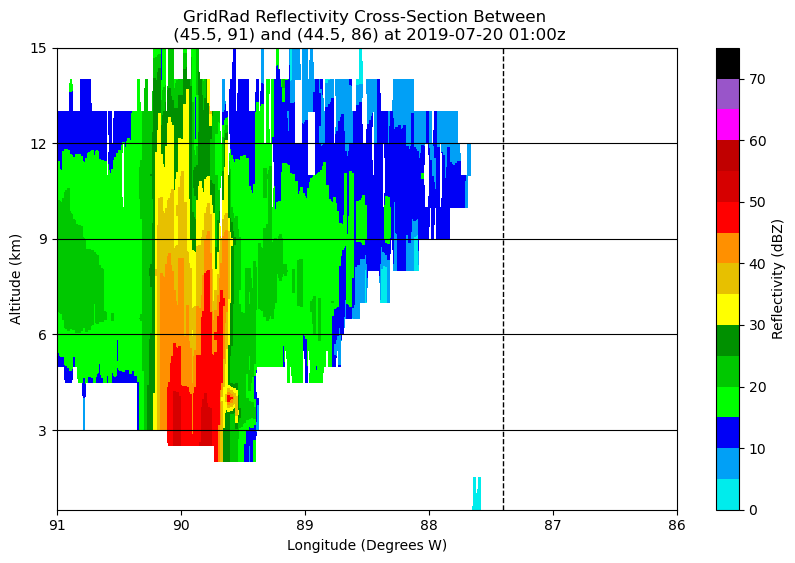

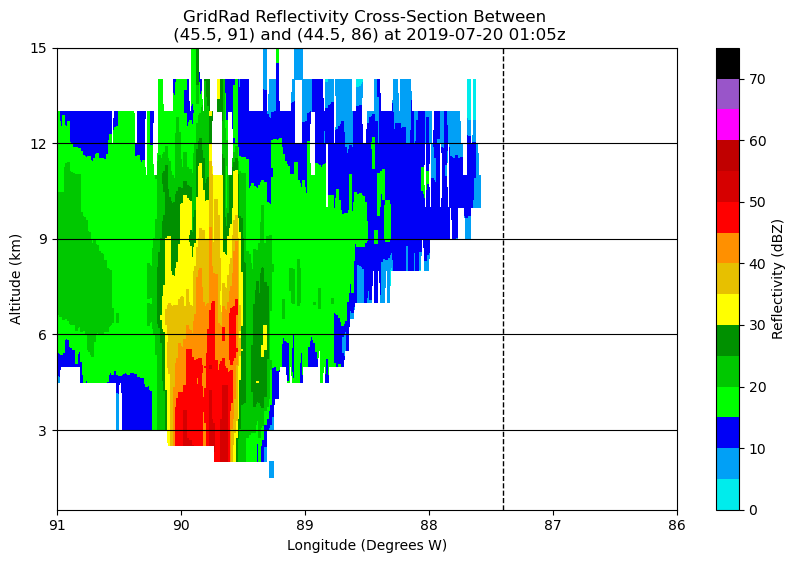

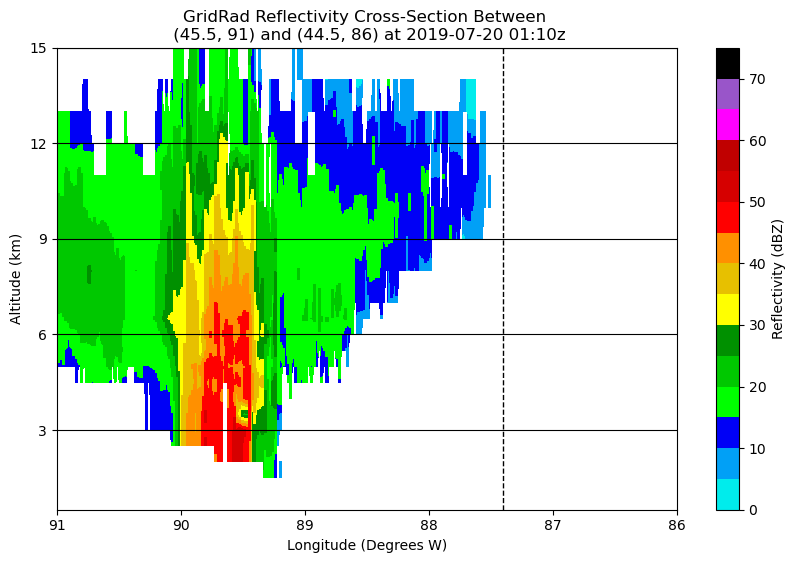

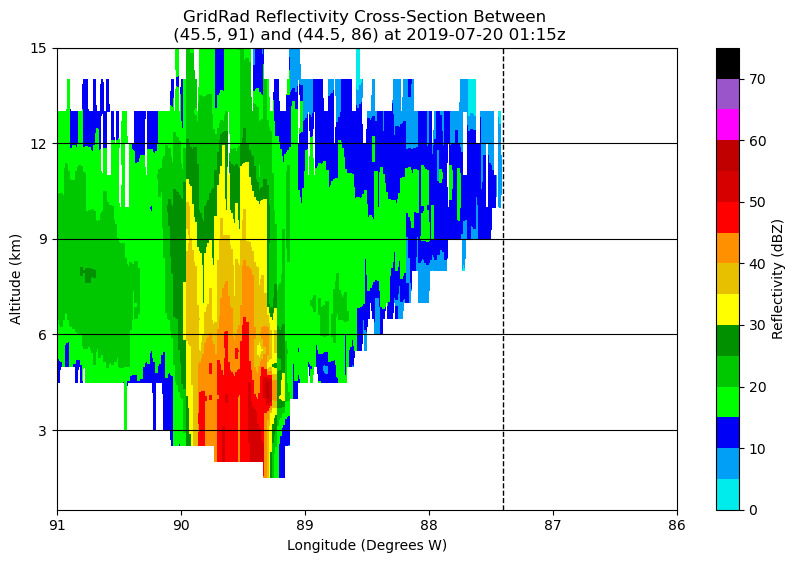

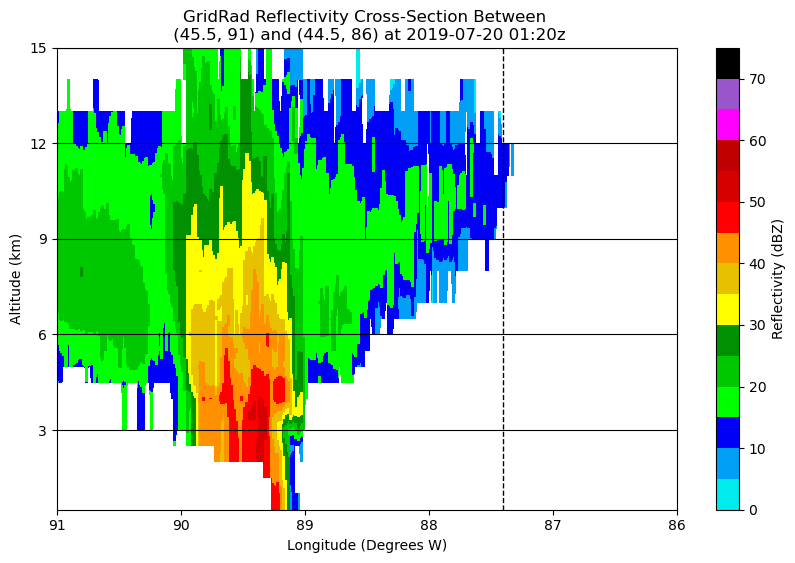

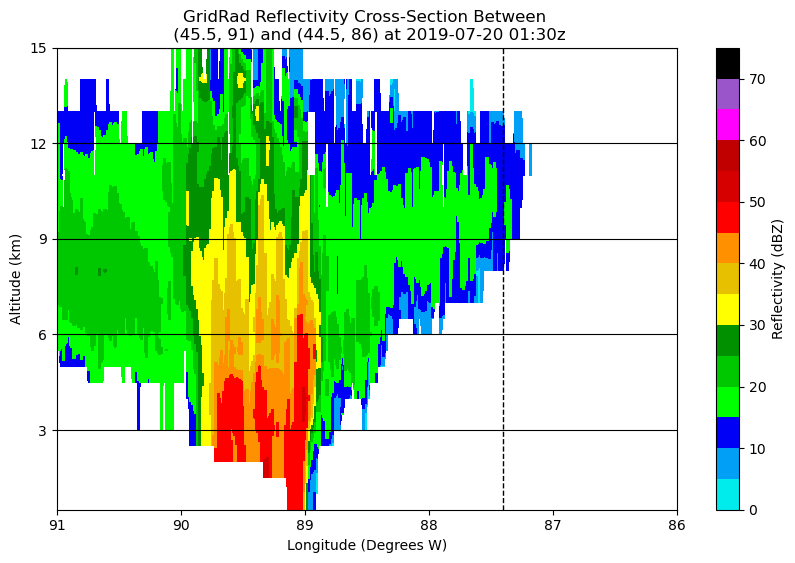

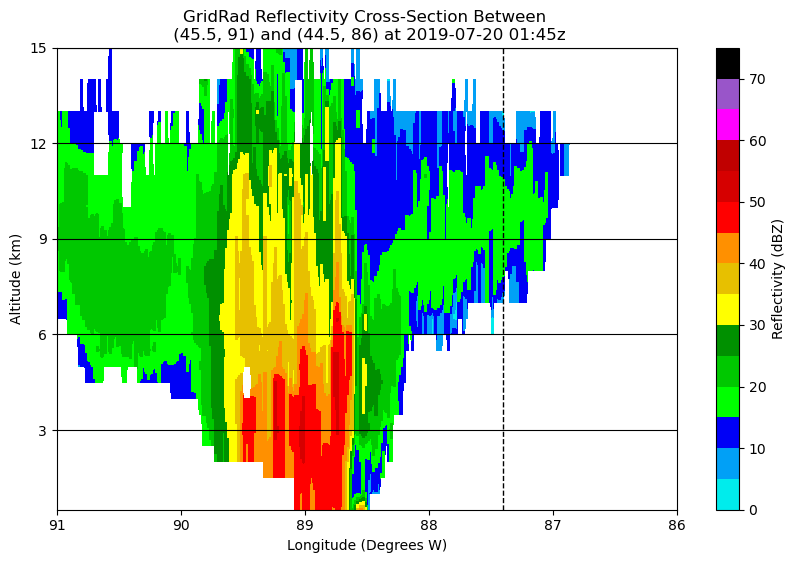

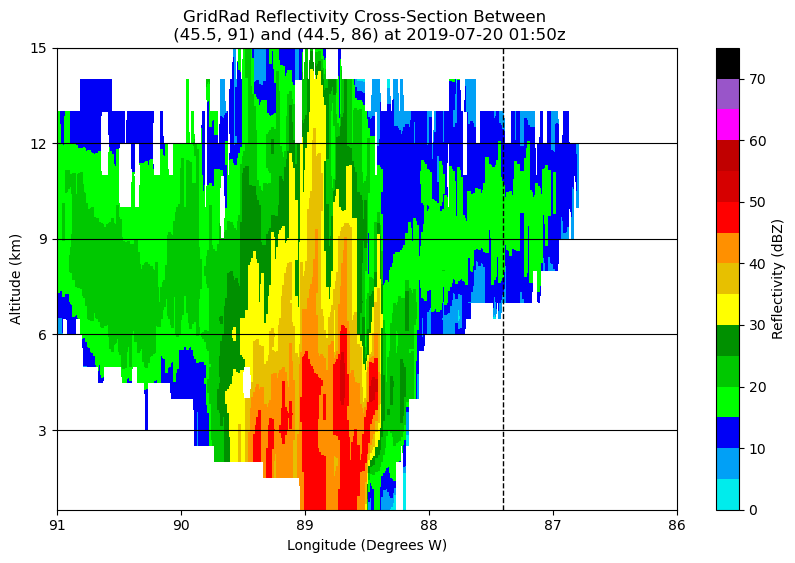

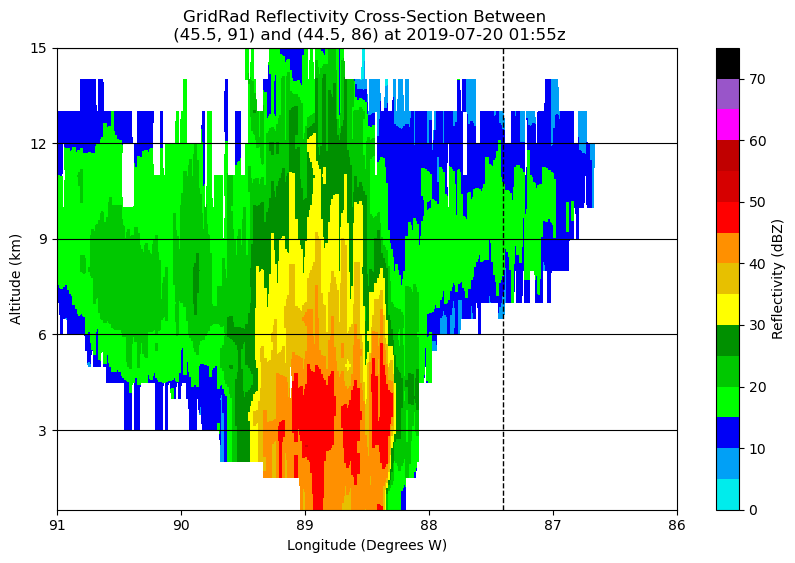

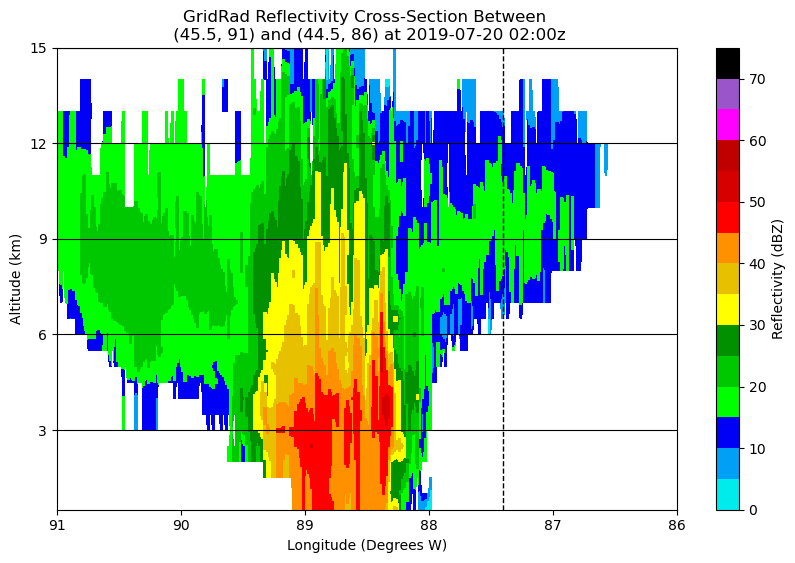

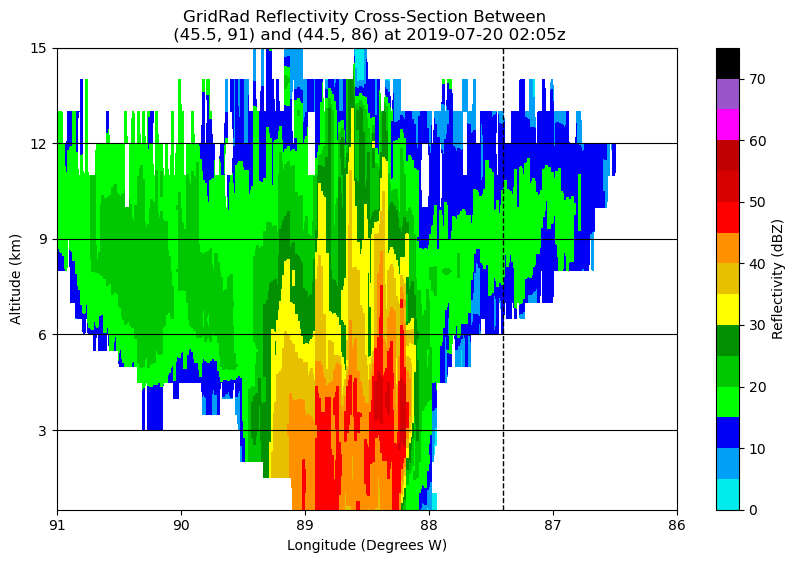

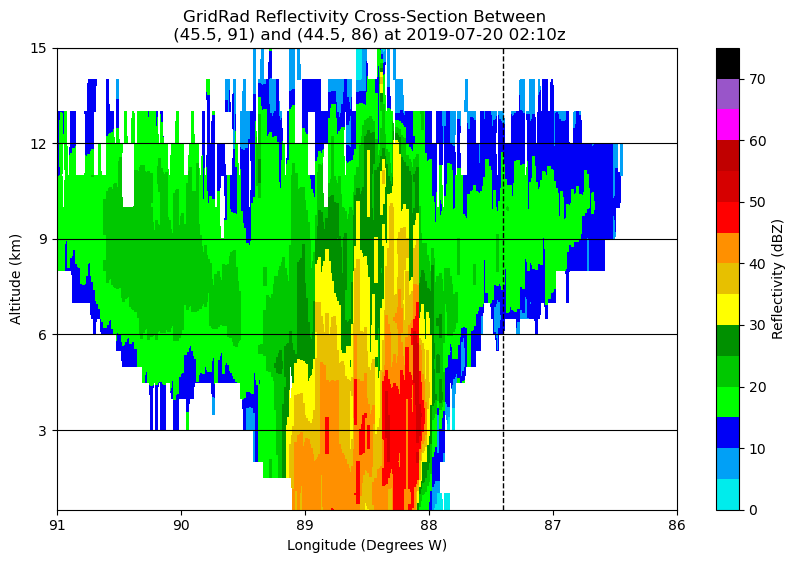

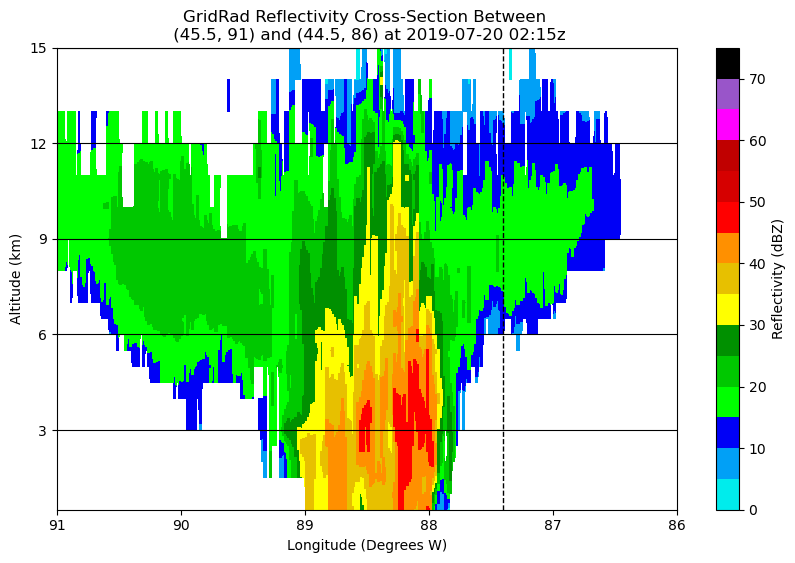

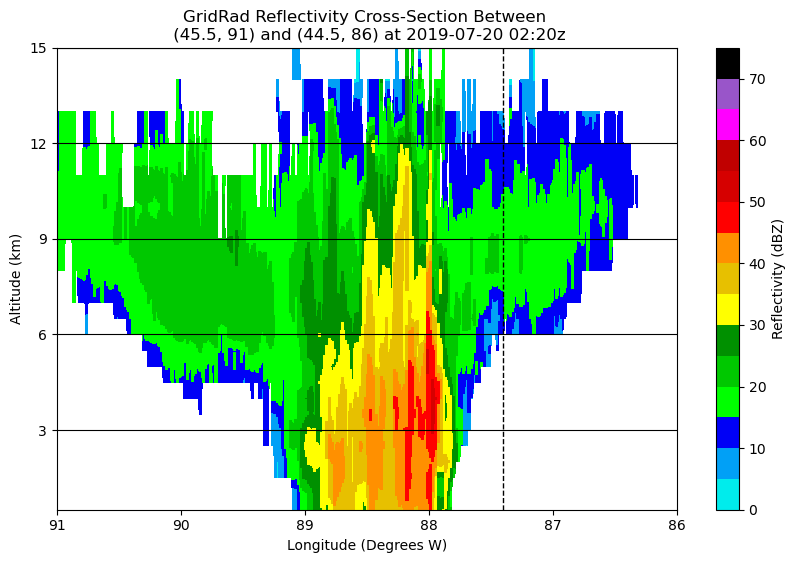

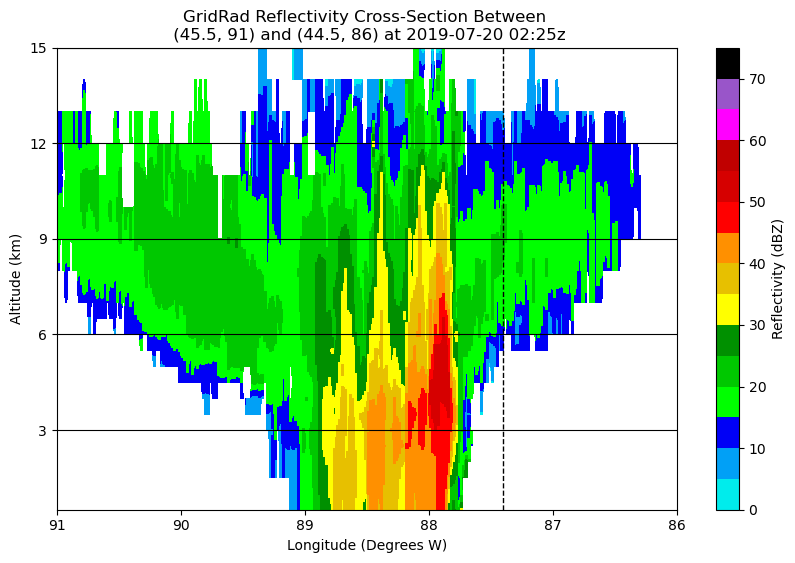

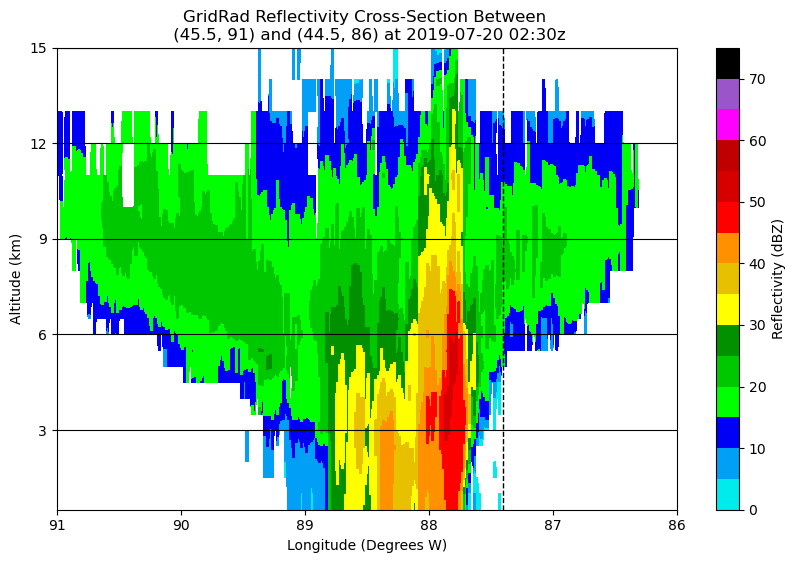

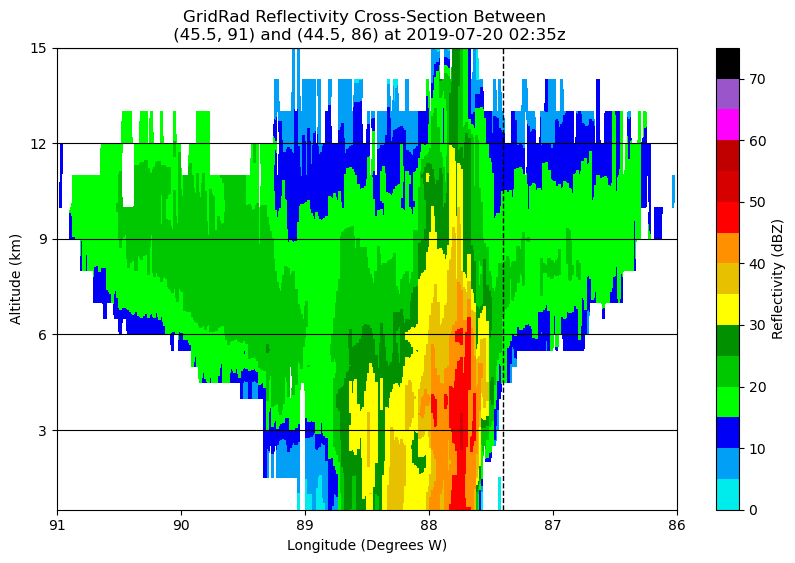

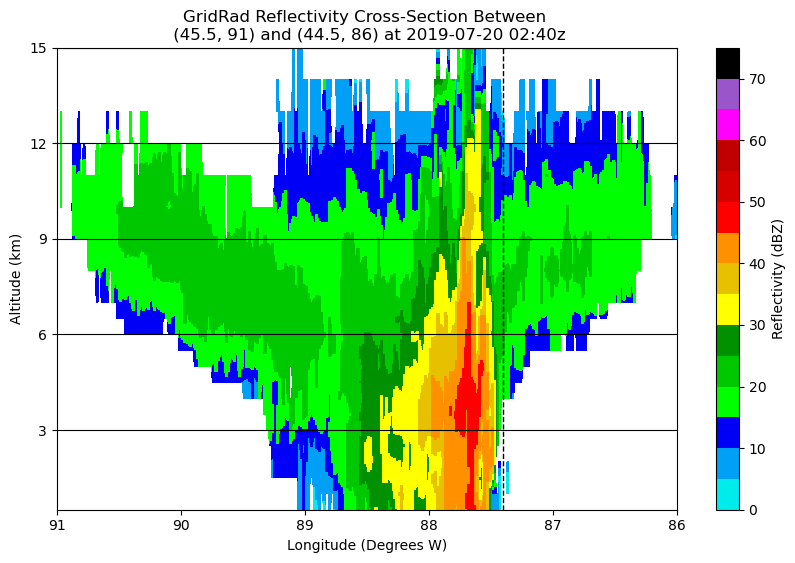

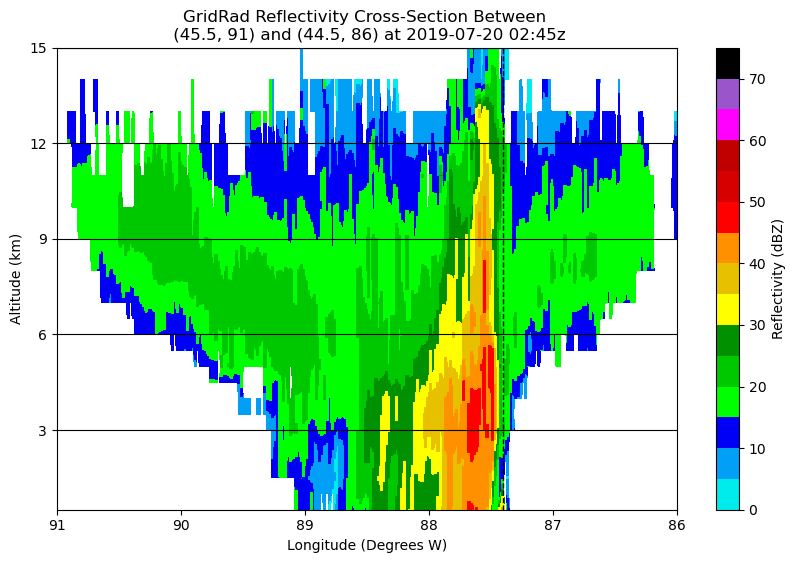

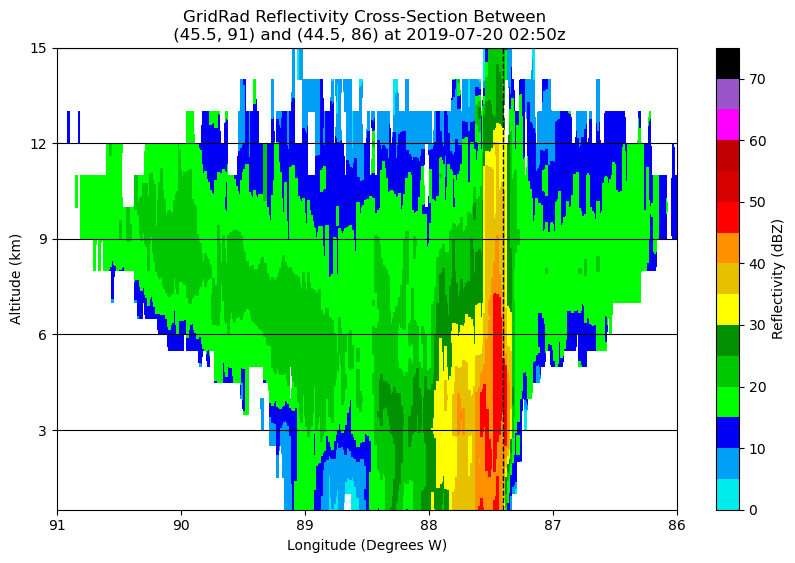

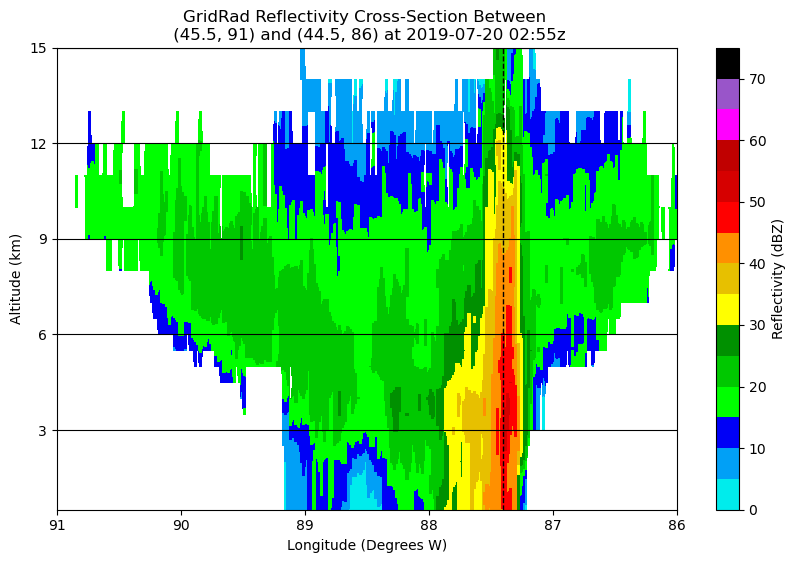

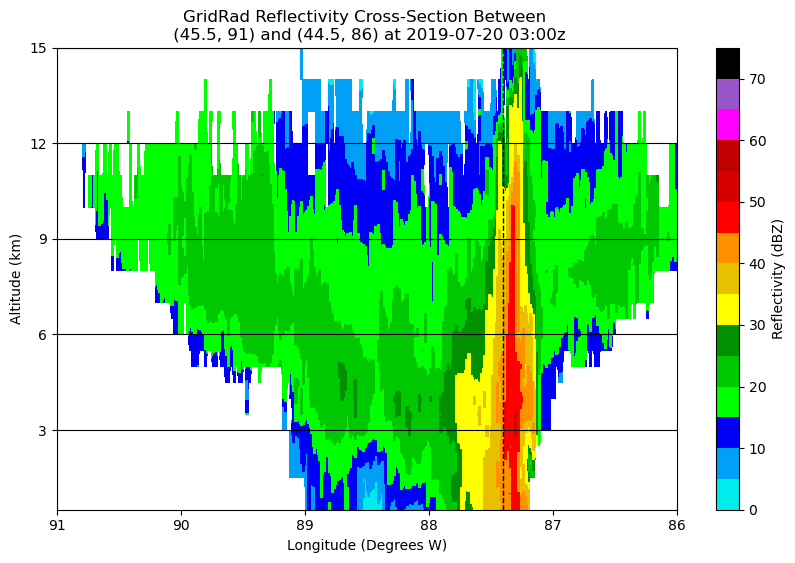

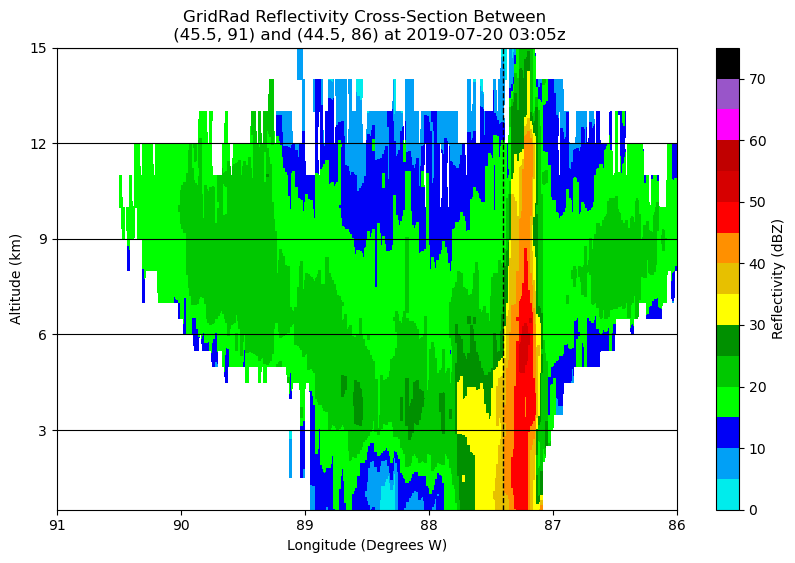

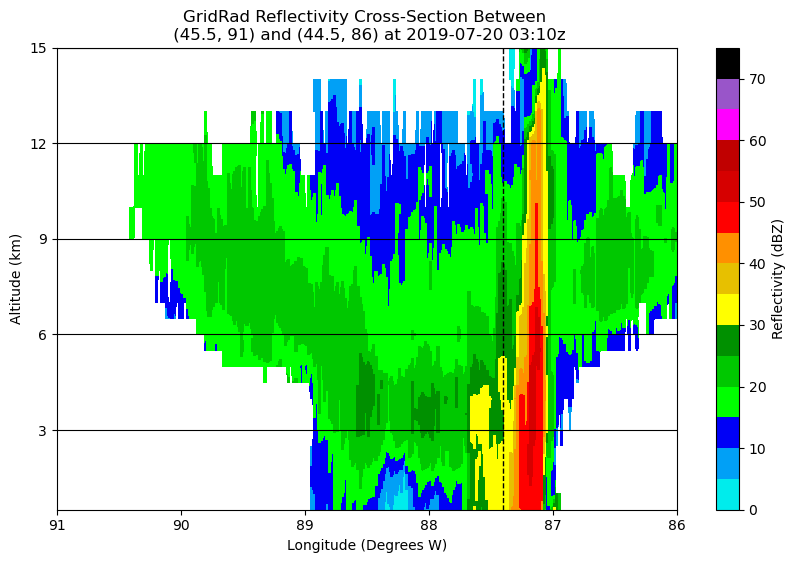

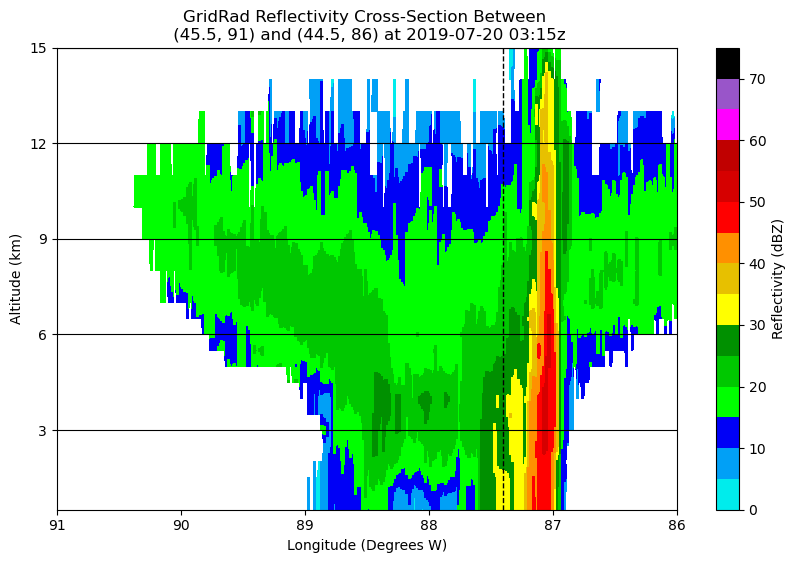

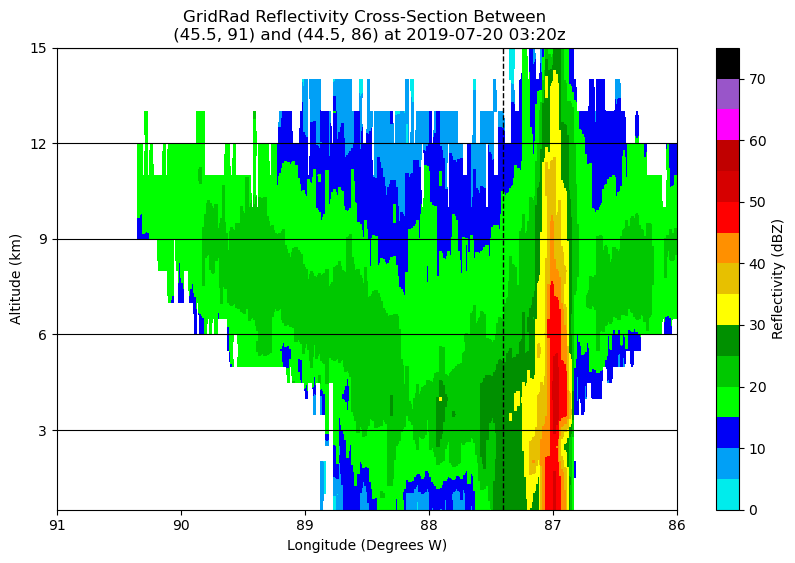

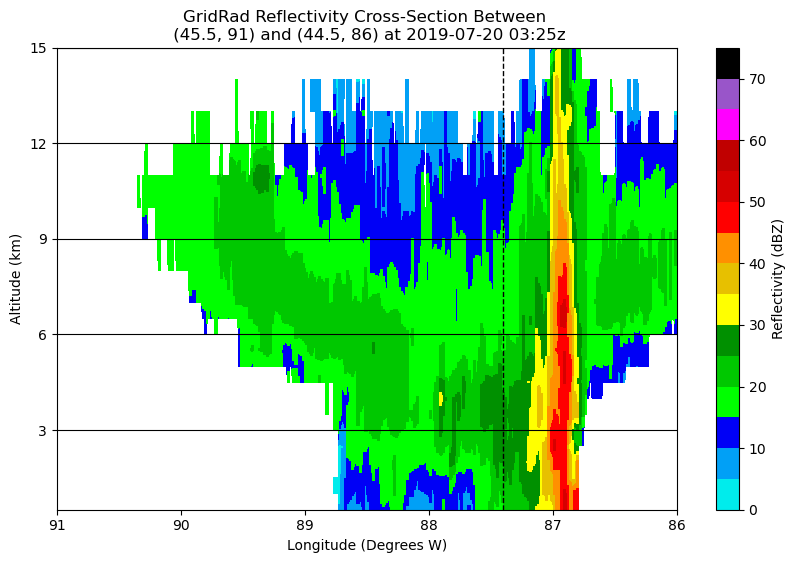

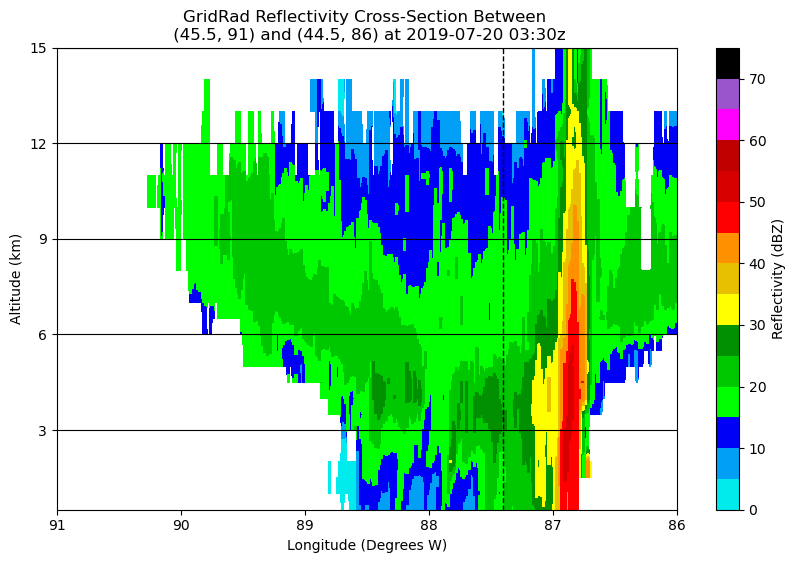

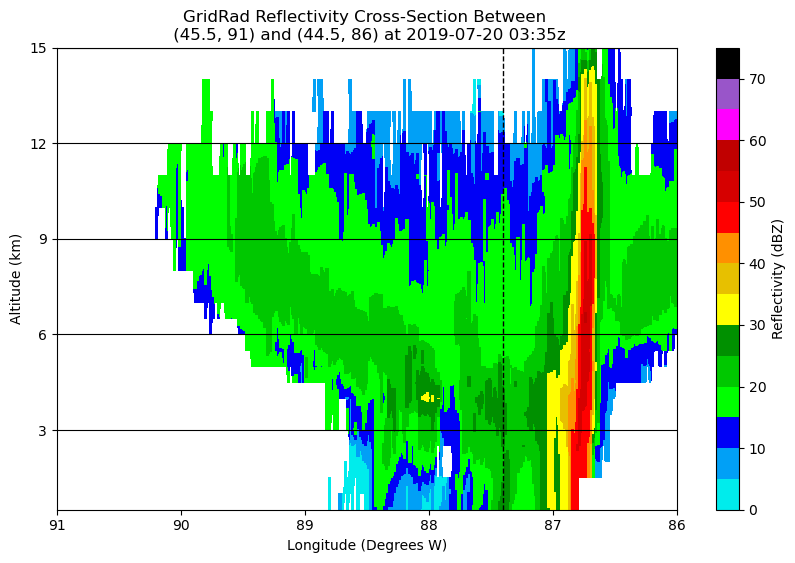

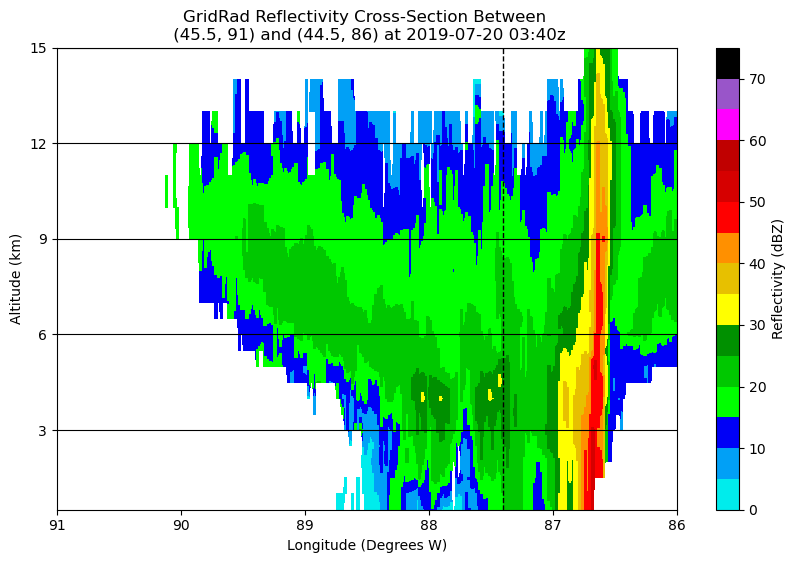

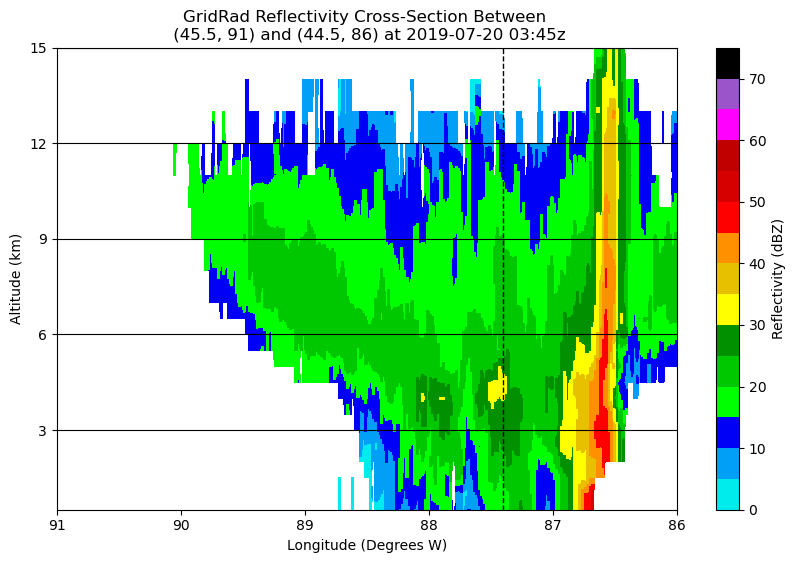

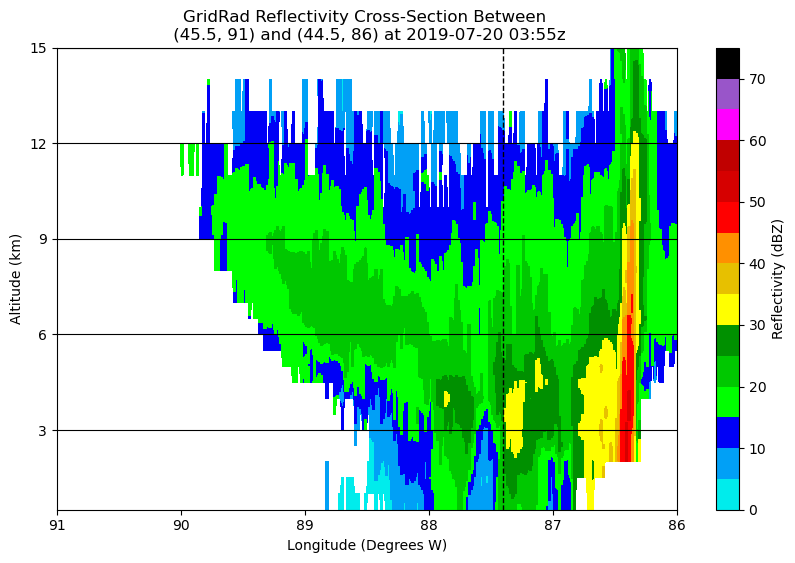

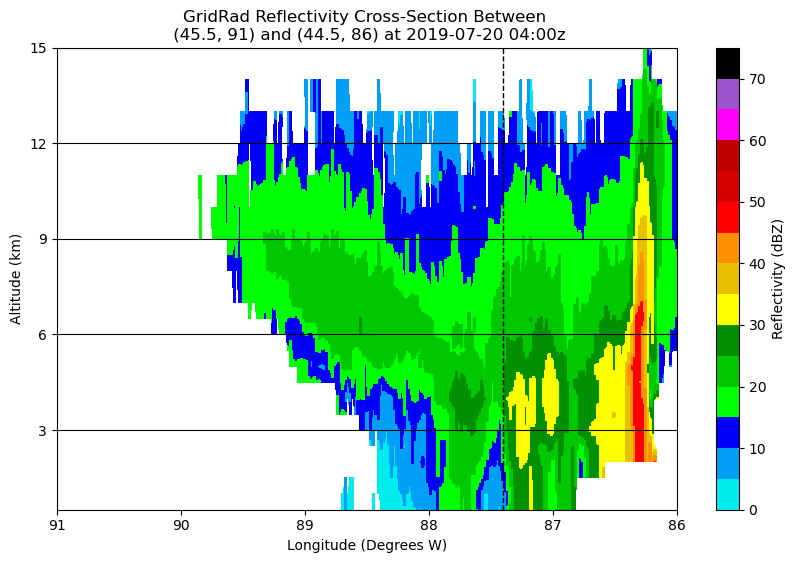

In [41]:
directory = 'c:\\Users\\Tony\\Desktop\\METR 4990\\gridcross'
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        file_path = os.path.join(directory, filename)
        ds = read_file(file_path)
        ds = filter(ds)
        ds = remove_clutter(ds, skip_weak_ll_echo=True)
        diagonal_cross(ds)